In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

from google.cloud import bigquery
client = bigquery.Client()

sql_file_path = './sql/validator_timing_games.sql'
with open(sql_file_path, 'r') as file:
    query = file.read()

df = client.query(query).to_dataframe() 

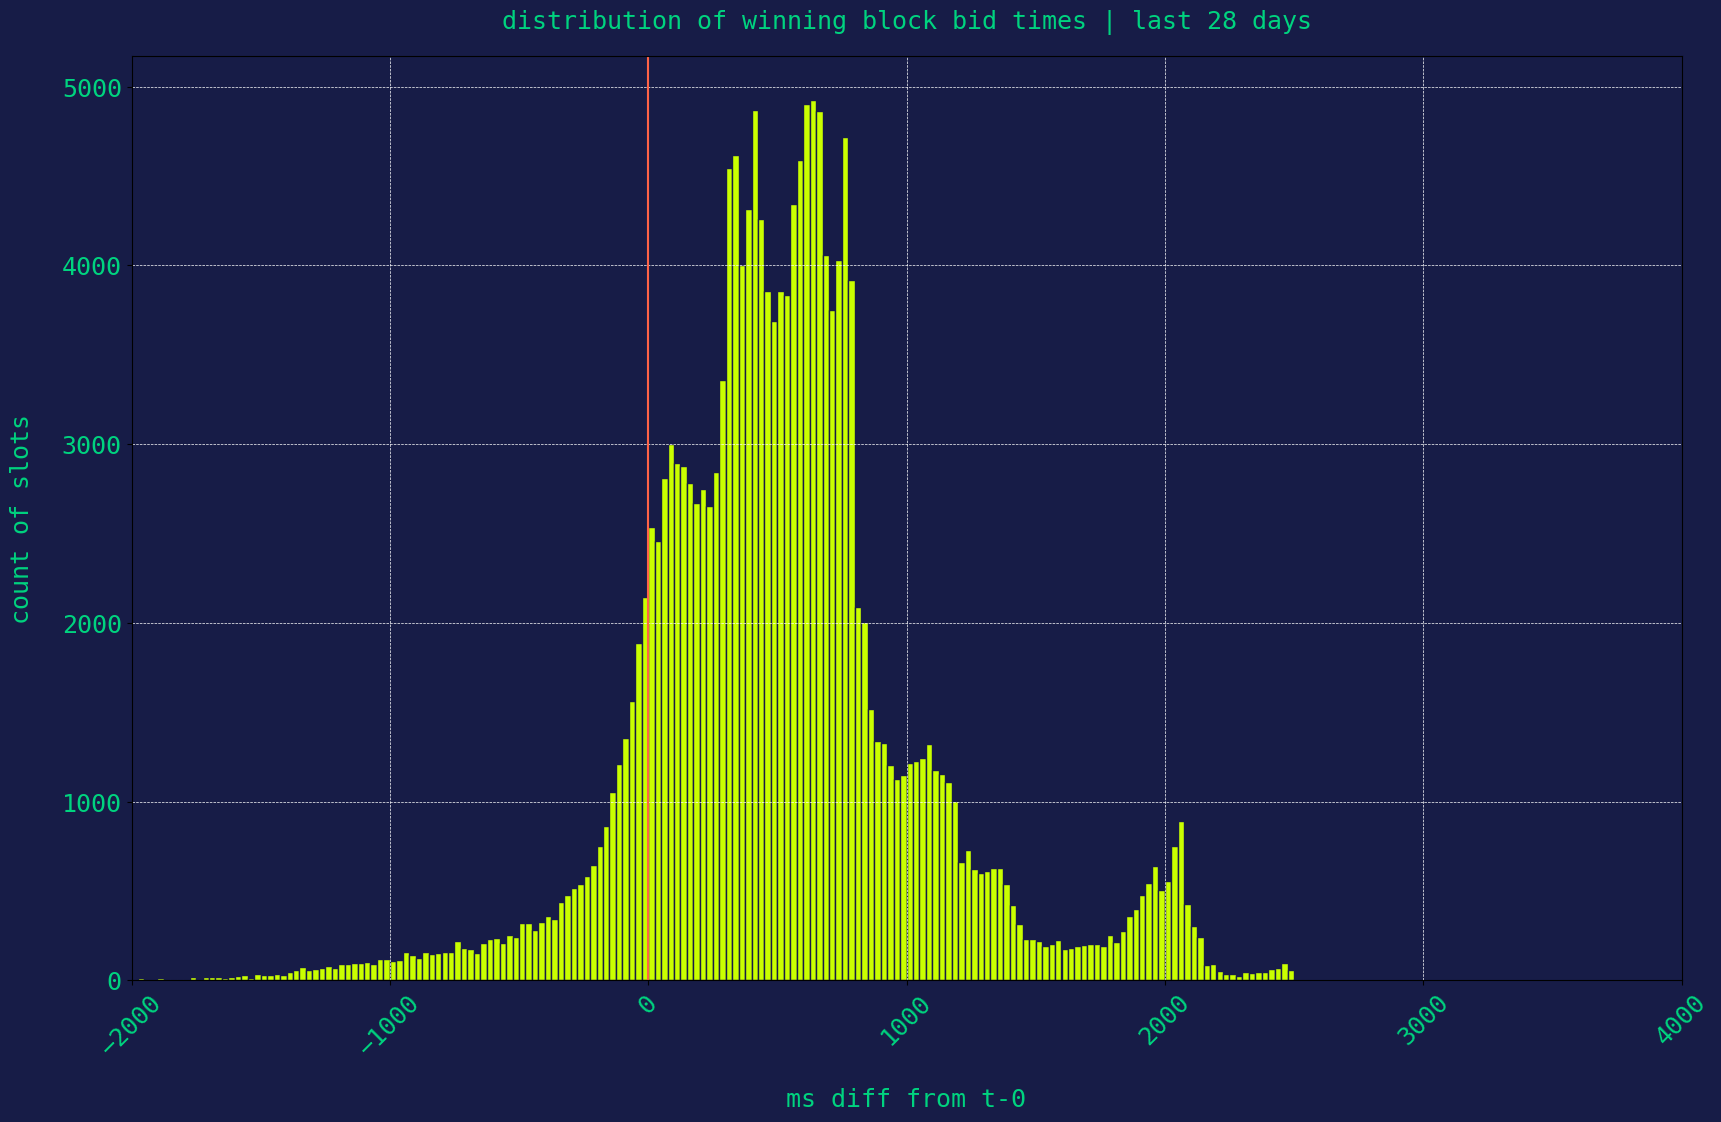

In [38]:
lime = '#caff00'
teal = '#00ff99'
green = '#00d37f'
navy = '#171c47'
dark_navy = '#171530'
title_color = green
label_color = green
chart_background_color = navy
chart_color = lime

# Find the adjusted minimum and maximum values for ms_diff
min_value = df['ms_diff'].min()
max_value = df['ms_diff'].max()
adjusted_min = min_value - (min_value % 25)
adjusted_max = max_value + (25 - max_value % 25)

# Create bin edges
bin_edges = np.arange(adjusted_min, adjusted_max + 25, 25)  # +25 to include the last edge
counts, _ = np.histogram(df['ms_diff'], bins=bin_edges)
max_count = counts.max()

plt.figure(figsize=(20, 12), facecolor=chart_background_color)
plt.axes(facecolor=chart_background_color)
plt.hist(df['ms_diff'], bins=bin_edges, color=chart_color, edgecolor=chart_background_color)
plt.axvline(0, color='tomato')
plt.title('distribution of winning block bid times | last 28 days', fontdict={'family': 'monospace', 'color' : green, 'size': 18}, pad=20)
plt.xlabel('ms diff from t-0', fontdict={'family': 'monospace', 'color' : label_color, 'size': 18}, labelpad=20)
plt.ylabel('count of slots', fontdict={'family': 'monospace', 'color' : label_color, 'size': 18}, labelpad=20)
plt.xlim(-2000, 4000)
plt.grid(True, color='white', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=18, fontname='monospace', rotation=45, color=label_color)
y_ticks = range(0, max_count + 1000, 1000)
plt.yticks(y_ticks, fontsize=18, fontname='monospace', color=label_color)
plt.show()

In [33]:
# Find the indices of the bins that are between 0 and 1000
bin_start = np.searchsorted(bin_edges, 0, side='right') - 1
bin_end = np.searchsorted(bin_edges, 1000, side='right')

# Create bins and counts for the range 0 to 1000
selected_bins = [(bin_edges[i], bin_edges[i+1]) for i in range(bin_start, bin_end - 1)]
selected_counts = counts[bin_start:bin_end - 1]
selected_histogram_table = pd.DataFrame({
    'Bin (Start, End)': selected_bins,
    'Count': selected_counts
})

sorted_histogram_table = selected_histogram_table.sort_values('Count', ascending=False)
sorted_histogram_table

Bin (Start, End)  Count
25       (625, 650)   4924
24       (600, 625)   4906
16       (400, 425)   4874
26       (650, 675)   4861
30       (750, 775)   4724
13       (325, 350)   4626
23       (575, 600)   4591
12       (300, 325)   4546
22       (550, 575)   4348
15       (375, 400)   4320
17       (425, 450)   4264
27       (675, 700)   4062
29       (725, 750)   4041
14       (350, 375)   4009
31       (775, 800)   3916
18       (450, 475)   3864
20       (500, 525)   3853
21       (525, 550)   3828
28       (700, 725)   3752
19       (475, 500)   3700
11       (275, 300)   3366
3         (75, 100)   3004
4        (100, 125)   2887
5        (125, 150)   2880
10       (250, 275)   2848
2          (50, 75)   2812
6        (150, 175)   2777
8        (200, 225)   2755
7        (175, 200)   2662
9        (225, 250)   2654
0           (0, 25)   2533
1          (25, 50)   2458
32       (800, 825)   2085
33       (825, 850)   1988
34       (850, 875)   1517
35       (875, 900)   1337
36       (900, 925)   1322
37       (925, 950)   1205
39      (975, 1000)   1141
38       (950, 975)   1125

## Distribution of winning bid relay timestamps versus t-0

The above figure shows the distribution of relay timestamps for winning bids versus `block_timestamp` aka `t-0`. `t-0` is the point at which all transactions that were available to be included in the block, are evaluated. In theory any transactions arriving after `t-0`, whether mev or not, should not be included in the block. The above figure paints a different story; the distribution is weighted significantly past `t-0` with spikes around 400, 600 & 800 milliseconds. Interestingly there are also two spikes around 1100 and 2100 milliseconds.

In order to analyse further, we will look at how the bid value changes with respect to `t-0`. In other words, how much extra value is available to validators that delay n milliseconds past `t-0`?

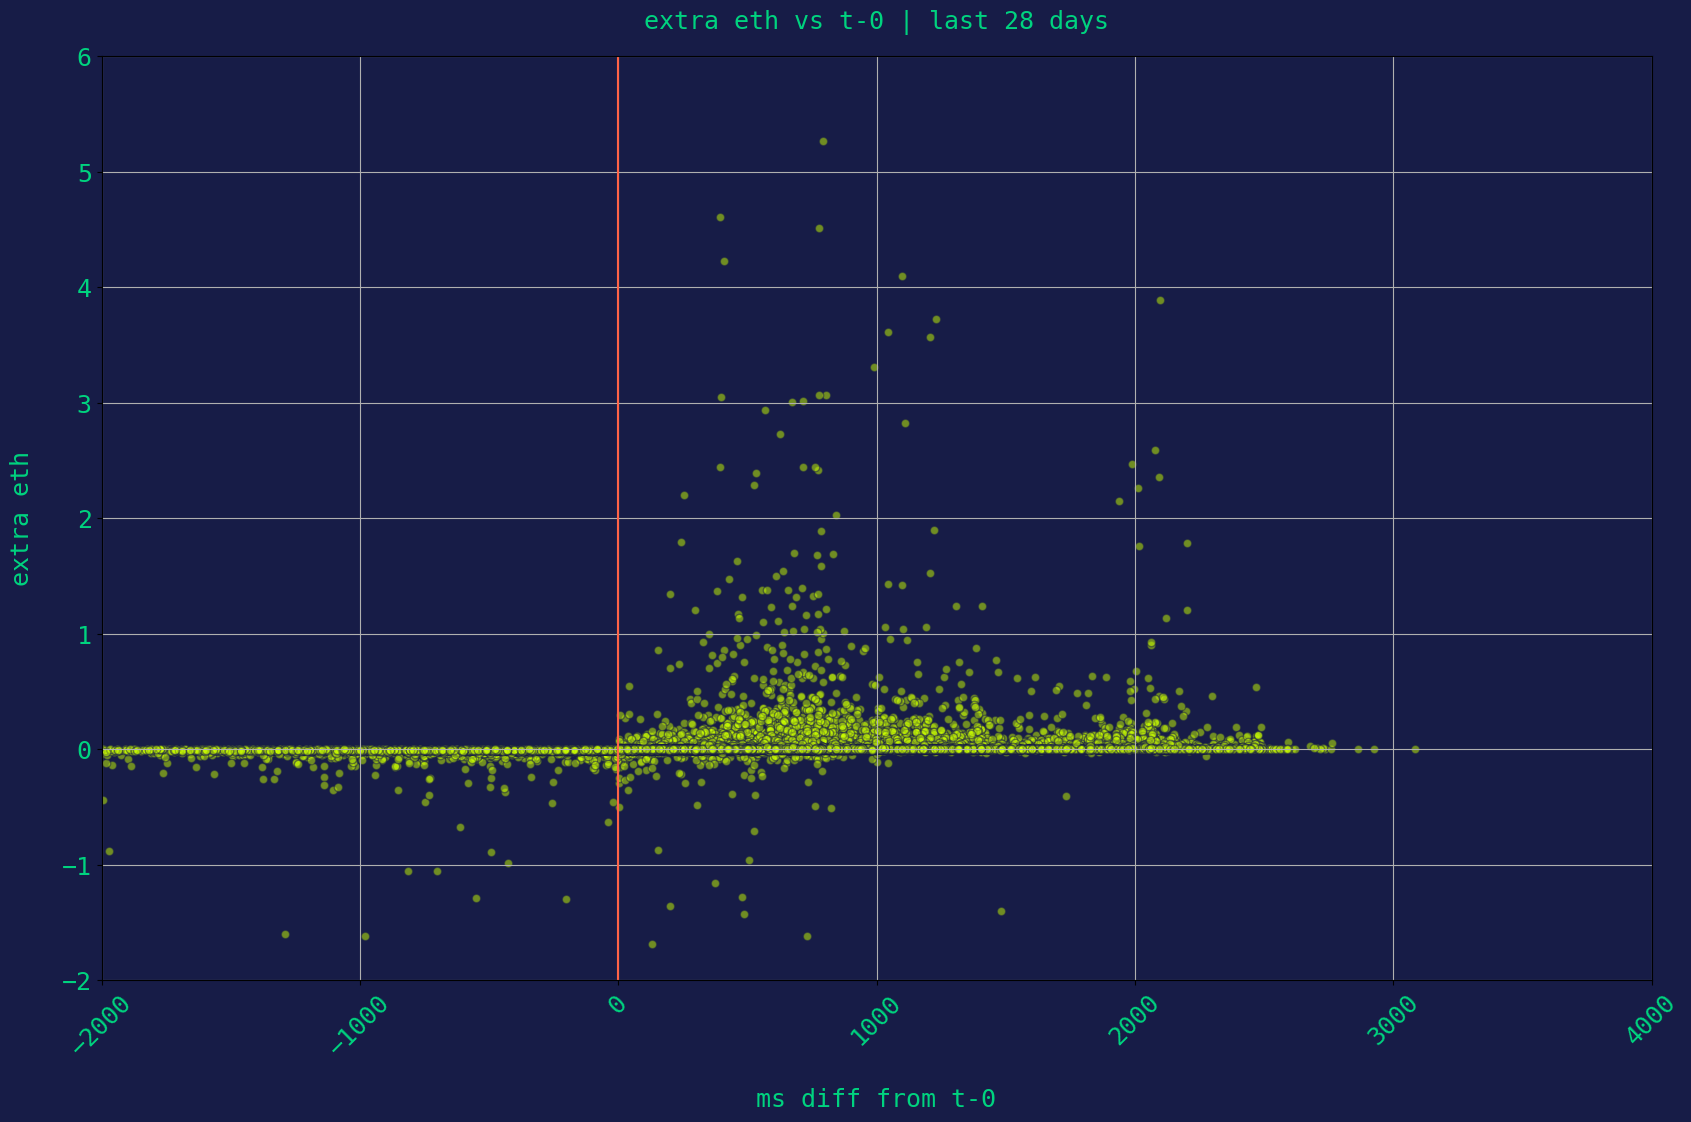

In [39]:
df['ms_diff'] = pd.to_numeric(df['ms_diff'], errors='coerce')
df['bid_delta_eth'] = pd.to_numeric(df['bid_delta_eth'], errors='coerce')

plt.figure(figsize=(20, 12), facecolor=chart_background_color)
plt.axes(facecolor=chart_background_color)
plt.scatter(df['ms_diff'], df['bid_delta_eth'], alpha=0.5, color=chart_color, edgecolor=chart_background_color)
plt.title('extra eth vs t-0 | last 28 days', fontdict={'family': 'monospace', 'color' : title_color, 'size': 18}, pad=20)
plt.xlabel('ms diff from t-0', fontdict={'family': 'monospace', 'color' : label_color, 'size': 18}, labelpad=20)
plt.ylabel('extra eth', fontdict={'family': 'monospace', 'color' : label_color, 'size': 18}, labelpad=20)
plt.axvline(0, color='tomato')
plt.xlim(-2000, 4000)
plt.ylim(-2, 6)
plt.xticks(fontsize=18, fontname='monospace', rotation=45, color=label_color)
plt.yticks(fontsize=18, fontname='monospace', color=label_color)
plt.grid(True)
plt.show()

This figure shows the same bids data however this time we're looking at how much extra eth was gained versus the best bid available at `t-0`. The x-axis, as was the case in the previous figure, is the relay `timestamp` of the winning bid versus `t-0`. The y-axis is the difference in eth between the winning bid and the best bid at `t-0`. 

Clearly there is more eth to be gained by delaying. This is purely due to more transactions being available to builders/searchers as time passes. What this means for validators is that should they respect `t-0`, they are essentially leaving eth on the table. This is not ideal and is a clear incentive for validators to not respect `t-0`. The amount of eth avaiable to validators does not appear to be correlated with the delay size. 

Interestingly, some validators end up with less eth than the best bid at `t-0`. This may be due to cross-domain or off chain opportunities dissapearing. This is hard to analyse without more data.

Let's take a look at the validators that gained the most eth by not respecting `t-0`.

In [20]:
# Filter the DataFrame for ms_diff > 0 and bid_delta_eth > 0
filtered_df = df[(df['ms_diff'] > 0) & (df['bid_delta_eth'] > 0)]

# Sort the filtered DataFrame by bid_delta_eth in descending order
sorted_df = filtered_df.sort_values(by='bid_delta_eth', ascending=False)

result = sorted_df[['ms_diff', 'bid_delta_eth', 'block_number', 'proposer_pubkey', 'builder_pubkey']]
result.head(10)

ms_diff  bid_delta_eth  block_number  \
46163       943      39.839748      18971364   
149686      172      30.618301      18926740   
70997       488      14.596883      18991878   
134939     1545      13.154018      18993061   
123701      441      11.883270      18926741   
71006      1568       7.415314      18829775   
9497        777       6.646081      18836490   
120937     1174       6.297879      18982359   
9167        792       5.270907      18965781   
178148      395       4.610201      18828836   

                                          proposer_pubkey  \
46163   0xb66e7c48fd1fa2bf3d2fb68454b80df302ffa150443b...   
149686  0x94e96f02b3391da18bccf8b338fbba240ffbfe5a848b...   
70997   0xad8642a0eb203cbdeefafcd65af33a219feb99cbe53d...   
134939  0xa6ecbc9236335db6a1903e3ddaaffbd7e36483b78848...   
123701  0xab6776bc5234bd73b7827aee978556e3ff8d07090756...   
71006   0xb1edd7fc73f918b48cb33b0184dd663dcad6ce014ef1...   
9497    0xb7d3a212f7a02c104862da9d159d819c546602a616a8...   
120937  0x8d7c141c95a9c45d55c9673cc1ceea5371ddb8b48e67...   
9167    0xaf7249107244c5b809240ba9a07170aaed927c07dd88...   
178148  0x833134d4fdfb58dd9590228fbe6b8a741cba4d05c1e8...   

                                           builder_pubkey  
46163   0x8d2b4626cd64c2889ff4822c6bdb25161bbd8a3976f0...  
149686  0xb194b2b8ec91a71c18f8483825234679299d146495a0...  
70997   0x945fc51bf63613257792926c9155d7ae32db73155dc1...  
134939  0xae2ffc6986c9a368c5ad2d51f86db2031d780f6ac9b2...  
123701  0xacb407cfb554255db2fbbb320f79bb7f1cc1e8d2dc43...  
71006   0x945fc51bf63613257792926c9155d7ae32db73155dc1...  
9497    0x987ff80fcf6c5ee530f4a4352884cb89fc5f57ab287e...  
120937  0xabcf636b7081e47edf77cf3f42b9e8b0c3a27a049b8e...  
9167    0x8e96593b5418b162e7f7d5c165fef2566a67d5e03357...  
178148  0xb9f88bc584a53fabb5b295e50638b20218c8b2303f3d...

Now lets look at the validators that lost the most eth even though they selected bids that were delivered after `t-0`.

In [21]:
# Filter the DataFrame for ms_diff > 0 and bid_delta_eth < 0
filtered_df = df[(df['ms_diff'] > 0) & (df['bid_delta_eth'] < 0)]

# Sort the filtered DataFrame by bid_delta_eth in ascending order
sorted_df = filtered_df.sort_values(by='bid_delta_eth', ascending=True)


result = sorted_df[['ms_diff', 'bid_delta_eth', 'block_number', 'proposer_pubkey', 'builder_pubkey']]
result.head(10)

ms_diff  bid_delta_eth  block_number  \
71244        28      -2.543716      19012724   
584         131      -1.682419      18822826   
94322       731      -1.613603      18937973   
85416       487      -1.426023      18850166   
130232     1483      -1.394661      18979013   
149843      202      -1.358456      18848600   
124925      481      -1.279007      18937694   
82236       373      -1.152718      18829161   
3352        506      -0.958304      18867973   
7066        154      -0.870977      18886844   

                                          proposer_pubkey  \
71244   0x9848b14ec65878ce90dd4bb57599916cd5fed736569d...   
584     0x8f2e582059533e2e0d96bf2a6eb57b6cfeaa2660fcc6...   
94322   0xb1a4a3ac1d86cf05748382dd7272e0f5dd04ad0fcfe2...   
85416   0xb8440f5ab61f57adfcc95f03794331081666d52b3d6d...   
130232  0x995ba28ad81f9950d04dd04936f010e8f5748515a02b...   
149843  0xa9cb4149fae00a641952cf20847cffa471269b2340a7...   
124925  0x94afe03f8392de38f316a2daf79705518958b75655fe...   
82236   0x86fc19b9b5b2c14f9f3bd2d81489fb6f27739108eadd...   
3352    0xab94ab93c9a832311e5bec6c6ae399580120f283694e...   
7066    0xa7a60a563ced6130a7fc3b5fd1bf16420aadbf2beabf...   

                                           builder_pubkey  
71244   0x945fc51bf63613257792926c9155d7ae32db73155dc1...  
584     0x8c0d45833884744d8cc4bb3438c3e93bcbc1436a25da...  
94322   0x978a35c39c41aadbe35ea29712bccffb117cc6ebcad4...  
85416   0x94a076b27f294dc44b9fd44d8e2b063fb129bc85ed04...  
130232  0xacfdcf458829f4693168a57d0659253069d687682bc6...  
149843  0xb194b2b8ec91a71c18f8483825234679299d146495a0...  
124925  0xacb407cfb554255db2fbbb320f79bb7f1cc1e8d2dc43...  
82236   0x94a076b27f294dc44b9fd44d8e2b063fb129bc85ed04...  
3352    0x8c0d45833884744d8cc4bb3438c3e93bcbc1436a25da...  
7066    0x82ba7cadcdfc1b156ba2c48c1c627428ba917858e62c...

Lets also delve into the validators that respected t-0 but lost eth. These are likely due to validators selecting bids too early and better bids arriving between when they selected the bid and `t-0`.

In [23]:
# Filter the DataFrame for ms_diff <= 0 and bid_delta_eth < 0
filtered_df = df[(df['ms_diff'] <= 0) & (df['bid_delta_eth'] < 0)]

# Sort the filtered DataFrame by bid_delta_eth in descending order
sorted_df = filtered_df.sort_values(by='bid_delta_eth', ascending=True)

result = sorted_df[['ms_diff', 'bid_delta_eth', 'block_number', 'proposer_pubkey', 'builder_pubkey']]
result.head(10)

ms_diff  bid_delta_eth  block_number  \
115768     -953      -2.139676      18929659   
111770     -979      -1.612667      18884097   
167658    -1290      -1.600342      18927859   
11472      -202      -1.296441      18829745   
114654     -550      -1.288632      19006155   
177401     -814      -1.053303      18980018   
130194     -702      -1.048969      18865579   
57382      -427      -0.981911      18941736   
11098      -491      -0.886090      19012751   
128504    -1972      -0.878215      18855414   

                                          proposer_pubkey  \
115768  0xa6b5a99b686c30fa02b74642c63f1ebb248045ae9d10...   
111770  0x8afbe6e4a570af796a6d63f2efd23316095bc938b2bb...   
167658  0xa62e9f504cc226a0c44ce46cdaacc92866c817894346...   
11472   0x954c81a3deec7f02309be4fde67062364c7748b85eac...   
114654  0x836937dfb286ba28138c5bfd6954a703672e2a39254c...   
177401  0xa166a37d57e2ae1967131d40c937991a88acaa37b13b...   
130194  0x83af4ac03ada4c720fc673ed2bbabbcece70b51016c6...   
57382   0x95e1b046a68c2bf5d1844d991f0bff0faef33b47d16b...   
11098   0xb0986904123bad0cdd528c52ad945f3f6c299f30d912...   
128504  0x95aaeb63d9e32af370fb3e13c4c97dd8746e1d73f581...   

                                           builder_pubkey  
115768  0xa2d994ea26d7c3b94b444fc2f2a6070d5cc8164e51d1...  
111770  0xa21a2f4807a2bcb6b07c10cea241322e0910c30869c1...  
167658  0xb67eaa5efcfa1d17319c344e1e5167811afbfe7922a2...  
11472   0xa4fb63c2ceeee73d1f1711fadf1c5357ac98cecb999d...  
114654  0xa21a2f4807a2bcb6b07c10cea241322e0910c30869c1...  
177401  0xb9f88bc584a53fabb5b295e50638b20218c8b2303f3d...  
130194  0xacfdcf458829f4693168a57d0659253069d687682bc6...  
57382   0x8e6df6e0a9ca3fd89db2aa2f3daf77722dc4fbcd15e2...  
11098   0xa412007971217a42ca2ced9a90e7ca0ddfc922a1482e...  
128504  0xacb407cfb554255db2fbbb320f79bb7f1cc1e8d2dc43...

Finally, to see all permutations we're just left with checking if any validators selected a bid earlier than `t-0` and ended up with more eth. We would assume not, but lets check.

In [24]:
# Filter the DataFrame for ms_diff > 0
filtered_df = df[(df['ms_diff'] < 0) & (df['bid_delta_eth'] > 0)]

# Sort the filtered DataFrame by bid_delta_eth in descending order
sorted_df = filtered_df.sort_values(by='bid_delta_eth', ascending=True)

result = sorted_df[['ms_diff', 'bid_delta_eth', 'block_number', 'proposer_pubkey', 'builder_pubkey']]
result.head(10)

ms_diff  bid_delta_eth  block_number  \
170257      -90       0.015069      18838980   

                                          proposer_pubkey  \
170257  0xa4dcbb27d87fb2c0c1e160bc31e625920acba1409337...   

                                           builder_pubkey  
170257  0xb783f81b2929e70c5b9a066d082d85dd12efa1c3e951...

In conclusion, selecting the best bid at `t-0` is not the most profitable strategy for validators. Some validators chose to select the best bid before `t-0` and this was even less optimal. 

This next section plots validator timings with respect to `t-0` as box plots. Only validators that mined >= 1000 blocks are included.

In [35]:
from plotly.subplots import make_subplots

df['ms_diff'] = pd.to_numeric(df['ms_diff'], errors='coerce')

validator_counts = df['validator_operator'].value_counts().reset_index()
validator_counts.columns = ['validator_operator', 'count']

validator_counts = validator_counts[validator_counts['count'] >= 1000]

df_filtered = df.merge(validator_counts, on='validator_operator', how='inner')

df_filtered.sort_values(by='count', ascending=False, inplace=True)

fig = make_subplots(rows=1, cols=1, 
                    specs=[[{"secondary_y": True}]])

for operator in df_filtered['validator_operator'].unique():
    operator_data = df_filtered[df_filtered['validator_operator'] == operator]['ms_diff']
    fig.add_trace(go.Box(y=operator_data, name=operator, marker_color=chart_color), row=1, col=1)

for operator in validator_counts['validator_operator']:
    count = validator_counts[validator_counts['validator_operator'] == operator]['count'].values[0]
    fig.add_trace(go.Bar(x=[operator], y=[count], name=operator, opacity=0.3, marker_color=chart_color), row=1, col=1, secondary_y=True)

fig.update_layout(
    plot_bgcolor=chart_background_color,
    paper_bgcolor=chart_background_color,
    font=dict(size=18, color=title_color, family='Courier New, monospace'),    
    title=dict(text='millisecond difference box plot | mined blocks | mined blocks > 1000 | last 28 days', x=0.45, y=0.95, xanchor='center', yanchor='top'),
    yaxis=dict(
        title='ms diff from t-0',
        showgrid=True,
        gridcolor='rgba(255, 255, 255, 0.3)',
        zeroline=True,
        zerolinecolor='tomato',
        dtick=1000,
        color=label_color
    ),
    yaxis2=dict(title='blocks mined', side='right', showgrid=False, color=label_color),
    xaxis=dict(title='validator - operator', tickangle=45, color=label_color),
    width=2000,
    height=1200,
    showlegend=False        
)

fig.show()

The above box plot displays all `validator | operator` pairs that mined at least 1000 blocks and how their blocks faired in comparison to `t-0` over the period. `validator | operator` are ordered (left to right) based on the number of blocks mined over the period. The first entry (`unknown - unknown`) is every block over the time range where we don't have a tag for both the `validator` and `operator` hence, it captures a wide range on entities and is pretty non conclusive in this analysis.

For all others entities what is clear is that on aggregate, most have their interquartile range slightly later than t-0. This may simply be due to geographical latency more than anything else. There are however, some interesting entities that appear to be maximising the timing games. The most exagerated ones are:

- lido | skillz
- lido | attestant (bvi) limited 

The box plot intentifies others that also have interesting interquartile ranges. see:

- binance | unknown
- lido | bridgetower
- lido | dsrv
- lido | p2p.org

To dig into this a bit further we can order entities by how much extra revenue (ETH) they made versus the best bid available at `t-0`.

In [37]:
bid_delta_eth_sum = df_filtered.groupby('validator_operator')['bid_delta_eth'].sum().reset_index()

fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

for operator in df_filtered['validator_operator'].unique():
    operator_data = df_filtered[df_filtered['validator_operator'] == operator]['ms_diff']
    fig.add_trace(go.Box(y=operator_data, name=operator, marker_color=chart_color), row=1, col=1)

for index, row in bid_delta_eth_sum.iterrows():
    fig.add_trace(go.Bar(x=[row['validator_operator']], y=[row['bid_delta_eth']], name=row['validator_operator'], opacity=0.3, marker_color=chart_color, showlegend=False), row=1, col=1, secondary_y=True)

fig.update_layout(
    title=dict(text='millisecond difference | extra eth vs t-0 | mined blocks > 1000 | last 28 days', x=0.45, y=0.95, xanchor='center', yanchor='top'),
    plot_bgcolor=chart_background_color,
    paper_bgcolor=chart_background_color,
    font=dict(size=18, color=title_color, family='Courier New, monospace'),    
    yaxis=dict(
        title='ms diff from t-0',
        showgrid=True,
        gridcolor='rgba(255, 255, 255, 0.3)',
        zeroline=True,
        zerolinecolor='tomato',
        dtick=1000,
        color=label_color
    ),

    yaxis2=dict(title='extra eth vs t-0', side='right', showgrid=False, color=label_color, range=[0, 700]),
    xaxis=dict(title='validator - operator', tickangle=45, color=label_color),
    width=2000,
    height=1200,
    showlegend=False
)

fig.show()

The idea here was to see if the same entities are highlighted by the amount of extra revenue they gained. As can be seen from the graph above, `lido | skills` and `lido | attestant (bvi) limited` apear to have made noticeable gains. The amount of extra revenue they obtained versus t-0 was as follows:

- lido | skillz -> 25 ETH
- lido | attestant -> 21 ETH

This graph keeps entities ordered by number of blocks mined, as defined in the previous chart, to allow for easy comparison. 